<a href="https://colab.research.google.com/github/ChristopherParrisMD/TabPFN-Benchmark-Project/blob/main/Heart__Disease_tabpfn_vs_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [ ]:
import mlcroissant as mlc

# Fetch the Croissant JSON-LD
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci/croissant/download')

# Check what record sets are in the dataset
record_sets = croissant_dataset.metadata.record_sets
print(record_sets)

# Fetch the records and put them in a DataFrame
record_set_df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))
record_set_df.head()

  -  [Metadata(Heart Disease Cleveland UCI)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


[RecordSet(uuid="heart_cleveland_upload.csv")]


,heart_cleveland_upload.csv/age,heart_cleveland_upload.csv/sex,heart_cleveland_upload.csv/cp,heart_cleveland_upload.csv/trestbps,heart_cleveland_upload.csv/chol,heart_cleveland_upload.csv/fbs,heart_cleveland_upload.csv/restecg,heart_cleveland_upload.csv/thalach,heart_cleveland_upload.csv/exang,heart_cleveland_upload.csv/oldpeak,heart_cleveland_upload.csv/slope,heart_cleveland_upload.csv/ca,heart_cleveland_upload.csv/thal,heart_cleveland_upload.csv/condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [ ]:
print(record_set_df.columns.tolist())

df = record_set_df

['heart_cleveland_upload.csv/age', 'heart_cleveland_upload.csv/sex', 'heart_cleveland_upload.csv/cp', 'heart_cleveland_upload.csv/trestbps', 'heart_cleveland_upload.csv/chol', 'heart_cleveland_upload.csv/fbs', 'heart_cleveland_upload.csv/restecg', 'heart_cleveland_upload.csv/thalach', 'heart_cleveland_upload.csv/exang', 'heart_cleveland_upload.csv/oldpeak', 'heart_cleveland_upload.csv/slope', 'heart_cleveland_upload.csv/ca', 'heart_cleveland_upload.csv/thal', 'heart_cleveland_upload.csv/condition']


In [ ]:
# Fix column names
df.columns = df.columns.str.replace(r'^.*?/', '', regex=True)
print(df.columns.tolist())

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']


In [ ]:
# Separate features and target
X = df.drop(columns=['condition'])
y = df['condition']

In [ ]:
# Column classification
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Target
target_col = 'condition'

In [ ]:
# Split
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import numpy as np

encoder = OrdinalEncoder()
X_cat = encoder.fit_transform(X[categorical_cols])

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])

# Combine
X_processed = np.hstack([X_num, X_cat])

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, classification_report


clf_tabpfn = TabPFNClassifier(device='cpu')
clf_tabpfn.fit(X_train, y_train)
y_pred_tabpfn = clf_tabpfn.predict(X_test)

print("TabPFN Accuracy:", accuracy_score(y_test, y_pred_tabpfn))
print(classification_report(y_test, y_pred_tabpfn))

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/classifier.py:462: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFN Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        32
           1       0.74      0.82      0.78        28

    accuracy                           0.78        60
   macro avg       0.78      0.79      0.78        60
weighted avg       0.79      0.78      0.78        60



In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.67      0.71      0.69        28

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



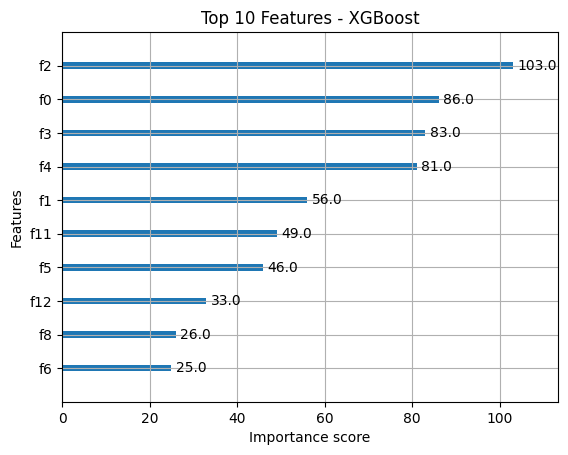

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(clf_xgb, max_num_features=10)
plt.title("Top 10 Features - XGBoost")
plt.show()
